In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Hyperparameter

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
lr = 0.0002
num_workers = 0
img_shape = (1, 28, 28)
g_input_dim = 100
num_epochs = 150

## MNIST Datasets

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

In [4]:
train_data = datasets.MNIST(root= "data", train = True, transform= transform, download= True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, num_workers= num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


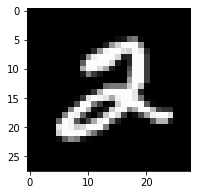

In [5]:
def visualize(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    images = images / 2 + 0.5  
    images = images.numpy()
    
    #get one image in batch
    img = np.squeeze(images[5])
    fig = plt.figure(figsize = (3,3)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

visualize(train_loader)

## Define the model

### Generator

In [0]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim = 784):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, output_dim)
    
        self.drop_out = nn.Dropout(0.3)
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.drop_out(x)

        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.drop_out(x)

        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.drop_out(x)

        out = F.tanh(self.fc4(x))
        return out

### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4  = nn.Linear(256, 1)

        self.dropout = nn.Dropout(0.3)
    def forward(self, img):
        x = img.view(img.size(0), -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)

        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)

        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = F.sigmoid(self.fc4(x))
        return out

In [10]:
G = Generator(g_input_dim, output_dim= 784).to(device)
D = Discriminator(input_dim= 784).to(device)

print(G)
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
  (drop_out): Dropout(p=0.3, inplace=False)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Define Losses and Optimizers

In [0]:
def real_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size).to(device)
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size).to(device) # fake labels = 0
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [0]:
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

## Training

In [13]:
D.train()
G.train()
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        #TRAIN DISCRIMINATOR
        d_optimizer.zero_grad()

        #Train with real images
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)

        #Train with fake images
        z = np.random.uniform(-1, 1, size= (batch_size, g_input_dim))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        #Combine loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        #TRAIN GENERATOR
        g_optimizer.zero_grad()

        z = np.random.uniform(-1, 1, size= (batch_size, g_input_dim))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)

        g_loss.backward()
        g_optimizer.step()
    
    print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
        epoch+1, num_epochs, d_loss.item(), g_loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  150] | d_loss: 0.8764 | g_loss: 2.4439
Epoch [    2/  150] | d_loss: 1.8278 | g_loss: 0.7024
Epoch [    3/  150] | d_loss: 0.1879 | g_loss: 2.8824
Epoch [    4/  150] | d_loss: 0.4842 | g_loss: 2.0858
Epoch [    5/  150] | d_loss: 0.7363 | g_loss: 2.1272
Epoch [    6/  150] | d_loss: 0.6268 | g_loss: 1.3041
Epoch [    7/  150] | d_loss: 0.5456 | g_loss: 1.8777
Epoch [    8/  150] | d_loss: 1.0571 | g_loss: 2.2855
Epoch [    9/  150] | d_loss: 0.6964 | g_loss: 2.3851
Epoch [   10/  150] | d_loss: 0.4972 | g_loss: 1.9148
Epoch [   11/  150] | d_loss: 0.7918 | g_loss: 1.5752
Epoch [   12/  150] | d_loss: 0.8072 | g_loss: 1.7118
Epoch [   13/  150] | d_loss: 0.8152 | g_loss: 2.2381
Epoch [   14/  150] | d_loss: 0.6802 | g_loss: 1.5932
Epoch [   15/  150] | d_loss: 1.0210 | g_loss: 1.6635
Epoch [   16/  150] | d_loss: 1.0705 | g_loss: 1.4667
Epoch [   17/  150] | d_loss: 0.8479 | g_loss: 1.5240
Epoch [   18/  150] | d_loss: 0.9351 | g_loss: 1.3650
Epoch [   19/  150] | d_loss

## Evaluation

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)).to("cpu"), cmap='Greys_r')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


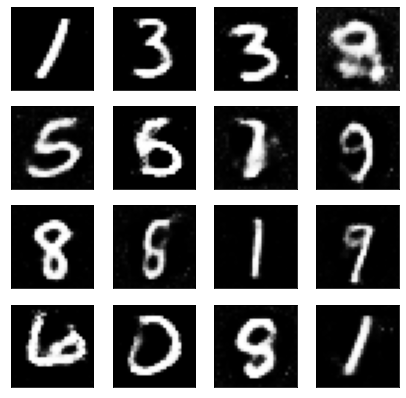

In [22]:
# randomly generated, new latent vectors
sample_size=20
rand_z = np.random.uniform(-1, 1, size=(sample_size, g_input_dim))
rand_z = torch.from_numpy(rand_z).float().to(device)

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)
view_samples(0, [rand_images])